In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import numpy as np

In [3]:
problem_class = "CarSequencing"
problem_title = ''
if problem_class == 'CarSequencing':
    problem_title = 'Car sequencing'
elif problem_class == 'CoveringArray':
    problem_title = 'Covering array'
elif problem_class == 'SocialGolfers':
    problem_title = 'Social golfers'
f = open(f"../data/datasets/{problem_class}.json")
dataset = json.load(f)
f.close()

In [31]:
def load_folder(folder):
    files = os.listdir(folder)
    res = {}
    for file in files:
        path = os.path.join(folder, file)
        if os.path.isdir(path):
            res[file] = load_folder(path)
        else:
            f = open(path)
            res[file] = json.load(f)
            f.close()
    return res

In [32]:
predictions = load_folder(f"../data/predictions/{problem_class}")

In [6]:
instance_dataset = {}
for datapoint in dataset:
    inst = datapoint["instance_name"]
    times = {t["combination"]: t["time"] for t in datapoint["all_times"]}
    instance_dataset[inst] = times

In [7]:
combinations = [t["combination"] for t in dataset[0]["all_times"]]

In [8]:
def is_competitive(vb, option):
    return (option < 10 or vb * 2 >= option) and option < 3600

In [9]:
if problem_class == "CarSequencing":
    combinations = [c for c in combinations if not "06_chPrunedLevels.eprime" in c]
combinations = sorted(combinations)

In [10]:
SAMPLE_KEY = list(predictions.keys())[1]
fold_instances = {"train": {i: [] for i in range(10)}, "validation": {i: [] for i in range(10)}, "test": {i: [] for i in range(10)}} #fold: instances of the fold
for key in predictions[SAMPLE_KEY]:
    strip = key.replace("_predictions_fold", "")
    strip = strip.split("_")
    set_type, fold = strip[0], int(strip[1])
    for pred in predictions[SAMPLE_KEY][key]: 
        instance = pred["inst"]
        fold_instances[set_type][fold].append(instance)

In [11]:
if problem_class == "CarSequencing":
    f = open("../data/features/CarSequencing/car_sequencing_fzn2feat.json")
    _fzn2feat_times = json.load(f)
    f.close()
    fzn2feat_times = {instance["inst"]: instance["time"] for instance in _fzn2feat_times}
else:
    df = pd.read_csv(f"../data/features/{problem_class}/fzn2feat_{problem_class}.csv")
    fzn2feat_times = {df.iloc[i]["inst"]: df.iloc[i]["time"] for i in range(len(df))}
f = open(f"../data/features/{problem_class}/dnn_times.json")
_dnn_times = json.load(f)
f.close()
dnn_times = {instance["inst"]: instance["time"] for instance in _dnn_times}

In [37]:
preditions_dataset = {}
for selection_algorithm in predictions.keys():
    if not selection_algorithm in preditions_dataset:
        preditions_dataset[selection_algorithm] = {}
    for set_type_prediction_fold in predictions[selection_algorithm]:
        strip = set_type_prediction_fold.replace("_predictions_fold", "")
        strip = strip.split("_")
        set_type, fold = strip[0], int(strip[1])
        if not set_type in preditions_dataset[selection_algorithm]:
            preditions_dataset[selection_algorithm][set_type] = {}
        if not fold in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][fold] = []
        for pred in predictions[selection_algorithm][set_type_prediction_fold]:
            inst = pred["inst"]
            choosen_option = pred["chosen_option"]
            pred_time = pred["time"] if "time" in pred else 0
            if "fzn2feat" in selection_algorithm:
                pred_time += fzn2feat_times[inst]
            elif "competitive" in selection_algorithm or "fully_neural" in selection_algorithm or 'only' in selection_algorithm:
                pred_time += dnn_times[inst]
            else:
                raise Exception(f"wut {selection_algorithm}?")
            if inst in fold_instances[set_type][fold]:
                preditions_dataset[selection_algorithm][set_type][fold].append(
                    instance_dataset[inst][choosen_option] + pred_time
                )
for selection_algorithm in preditions_dataset:
    for set_type in preditions_dataset[selection_algorithm]:
        for fold in preditions_dataset[selection_algorithm][set_type]:
            preditions_dataset[selection_algorithm][set_type][fold] = sum(preditions_dataset[selection_algorithm][set_type][fold])

In [38]:
for combination in combinations:
    preditions_dataset[combination] = {}
    for set_type in fold_instances.keys():
        preditions_dataset[combination][set_type] = {}
        for fold in fold_instances[set_type].keys():
            preditions_dataset[combination][set_type][fold] = []
            for inst in fold_instances[set_type][fold]:
                preditions_dataset[combination][set_type][fold] += [instance_dataset[inst][combination]]
            preditions_dataset[combination][set_type][fold] = sum(preditions_dataset[combination][set_type][fold])
     
preditions_dataset["virtual best"] = {}       
for set_type in fold_instances.keys():
    preditions_dataset["virtual best"][set_type] = {}
    for fold in fold_instances[set_type].keys():
        preditions_dataset["virtual best"][set_type][fold] = []
        for inst in fold_instances[set_type][fold]:
            preditions_dataset["virtual best"][set_type][fold] += [min(instance_dataset[inst].values())]
        preditions_dataset["virtual best"][set_type][fold] = sum(preditions_dataset["virtual best"][set_type][fold])

In [39]:
opt_times = {comb["combination"]:0 for comb in dataset[0]["all_times"]}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        opt_times[t["combination"]] += t["time"]
sb_key = min(opt_times.items(), key = lambda x: x[1])[0]
print(sb_key)

chuffed_02_compact.eprime


In [40]:
def key_transform_p1(key):
    if "eprime" in key:
        key = key.replace("0","M").replace("or-tools-1","OR-Tools").replace("5","3").replace("cplex", "CPLEX").replace("chuffed", "Chuffed").replace("kissat", "Kissat")
        return "-".join(key.split("_")[:2])
    else:
        return key.replace("_", "-")
def key_transform(key):
    k = key_transform_p1(key)
    if key != "virtual best":
        string =  "-".join([k.split("-")[-1]] + k.split("-")[:-1])
        return string
    return key.replace("virtual best", "VBS")

In [41]:
def transform(name:str) -> str:
    if "probabilities_only" == name:
        return '($p, K$)'
    if "tanh_only" == name:
        return '($t, K$)'
    if "eprime" in name:
        return r"$SB$"
    if "virtual best" in name:
        return r"$VB$"
    if "fully_neural" == name:
        return f"BNN"
    features = ""
    algorithm = ""
    if "fully_neural" in name:
        features = "bNN"
    elif "competitive" in name:
        features = "cNN"
    elif "fzn2feat" in name:
        features = "F2F"
    else:
        raise Exception(f"features {name} unrecognized")
    if "autofolio_untuned" in name:
        algorithm = "A"
    elif "autofolio_tuned" in name:
        algorithm = "A"
    elif "kmeans" in name:
        algorithm = "K"
    else:
        raise Exception(f"algorithm {name} unrecognized")
    return fr"(${features}, {algorithm}$)"

In [42]:
comparison = {}
for selection_algorithm in predictions.keys():
    if not "kmeans" in selection_algorithm or "fully_neural" in selection_algorithm:
        continue
    if not selection_algorithm in comparison:
        comparison[selection_algorithm + "_pred_time"] = {}
        comparison[selection_algorithm + "_no_pred_time"] = {}
    for set_type_prediction_fold in predictions[selection_algorithm]:
        strip = set_type_prediction_fold.replace("_predictions_fold", "")
        strip = strip.split("_")
        set_type, fold = strip[0], int(strip[1])
        if set_type != "test":
            continue
        if not fold in comparison[selection_algorithm + "_pred_time"]:
            comparison[selection_algorithm + "_pred_time"][fold] = []
            comparison[selection_algorithm + "_no_pred_time"][fold] = []
        for pred in predictions[selection_algorithm][set_type_prediction_fold]:
            inst = pred["inst"]
            choosen_option = pred["chosen_option"]
            pred_time = pred["time"] if "time" in pred else 0
            if "fzn2feat" in selection_algorithm:
                pred_time += fzn2feat_times[inst]
            elif "competitive" in selection_algorithm:
                pred_time += dnn_times[inst]
            else:
                raise Exception(f"wut {selection_algorithm}?")
            if inst in fold_instances[set_type][fold]:
                comparison[selection_algorithm + "_pred_time"][fold].append(
                    instance_dataset[inst][choosen_option] + pred_time
                )
                comparison[selection_algorithm + "_no_pred_time"][fold].append(
                    instance_dataset[inst][choosen_option]
                )
comp_results = {}
for selection_algorithm in comparison:
    for fold in comparison[selection_algorithm]:
        s = np.average(comparison[selection_algorithm][fold])
        key = "fzn2feat" if "fzn2feat" in selection_algorithm else "cNN"
        key += " + E-time" if not "no_pred_time" in selection_algorithm else ""
        if not key in comp_results:
            comp_results[key] = {}
        comp_results[key][fold] = f"{s:,.2f}"

In [ ]:
df = pd.DataFrame(comp_results).sort_index()
df.index.name = "fold"
print(df.to_latex())
# df

\begin{tabular}{lllll}
\toprule
 & fzn2feat + E-time & fzn2feat & cNN + E-time & cNN \\
fold &  &  &  &  \\
\midrule
0 & 1,547.11 & 1,224.51 & 209.45 & 209.44 \\
1 & 1,163.31 & 848.11 & 268.35 & 268.35 \\
2 & 518.72 & 199.68 & 234.85 & 234.85 \\
3 & 1,175.69 & 857.06 & 253.20 & 253.20 \\
4 & 528.35 & 216.90 & 275.22 & 275.22 \\
5 & 481.67 & 176.76 & 181.12 & 181.11 \\
6 & 841.24 & 535.98 & 221.02 & 221.02 \\
7 & 849.04 & 548.80 & 268.51 & 268.51 \\
8 & 911.93 & 594.83 & 280.15 & 280.15 \\
9 & 1,228.29 & 916.30 & 168.23 & 168.23 \\
\bottomrule
\end{tabular}



In [43]:
str_len = 40
def pad_around(string):
    before = True
    while len(string) < str_len:
        if before:
            string = " " + string
        else:
            string = string + " "
        before = not before     
    return string   

In [44]:
for set_to_use in ['test']:
    plot_predictions = {}
    for key in preditions_dataset.keys():
        try:
            # if key == sb_key or ("NN" in transform(key) and not "untuned" in key) or key == "virtual best" or 'only' in key:
            if transform(key) == "($cNN, K$)" or transform(key) == "($F2F, K$)" or transform(key) == '$SB$':
                plot_predictions[transform(key)] = preditions_dataset[key][set_to_use]
        except:
            print(key)

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: item[0]))
    print(sorted_data['$SB$'])
    print(sorted_data['($F2F, K$)'])
    sorted_data = {k: {fold:f"{v/sorted_data['$SB$'][fold]:.4f}" for fold, v in elements.items()} for k, elements in sorted_data.items()}
pd.DataFrame(sorted_data)

{0: 22087126.969999995, 1: 21869383.09, 2: 21654367.37999998, 3: 22767379.880000014, 4: 21836916.610000003, 5: 22335595.48999998, 6: 22338840.30000002, 7: 22487167.320000004, 8: 21544205.630000003, 9: 21009075.39}
{7: 359648.0604888338, 8: 290487.92544775014, 0: 135296.2417622378, 6: 289276.5388460441, 2: 279600.9340393356, 4: 356208.4816909888, 9: 182932.95912300085, 3: 234600.55708870868, 5: 251728.280136938, 1: 308306.76420393004}


,$SB$,"($F2F, K$)","($cNN, K$)"
0,1.0000,0.0061,0.0139
1,1.0000,0.0141,0.0073
2,1.0000,0.0129,0.0100
3,1.0000,0.0103,0.0080
4,1.0000,0.0163,0.0207
5,1.0000,0.0113,0.0081
6,1.0000,0.0129,0.0164
7,1.0000,0.0160,0.0083
8,1.0000,0.0135,0.0096
9,1.0000,0.0087,0.0073


In [45]:
preditions_dataset.keys()

dict_keys(['autofolio_untuned_competitive', 'autofolio_untuned_fzn2feat', 'autofolio_tuned_competitive', 'fully_neural', 'probabilities_only', 'autofolio_tuned_fully_neural', 'autofolio_tuned_fzn2feat', 'kmeans_fully_neural', 'kmeans_fzn2feat', 'tanh_only', 'kmeans_competitive', 'chuffed_01_compact.eprime', 'chuffed_02_compact.eprime', 'chuffed_05_nochAllLevels_2.eprime', 'cplex_01_compact.eprime', 'cplex_02_compact.eprime', 'cplex_05_nochAllLevels_2.eprime', 'kissat_01_compact.eprime', 'kissat_02_compact.eprime', 'kissat_05_nochAllLevels_2.eprime', 'or-tools-1_01_compact.eprime', 'or-tools-1_02_compact.eprime', 'or-tools-1_05_nochAllLevels_2.eprime', 'virtual best'])

In [46]:
def get_label(x):
    return f'{x:.2f}'

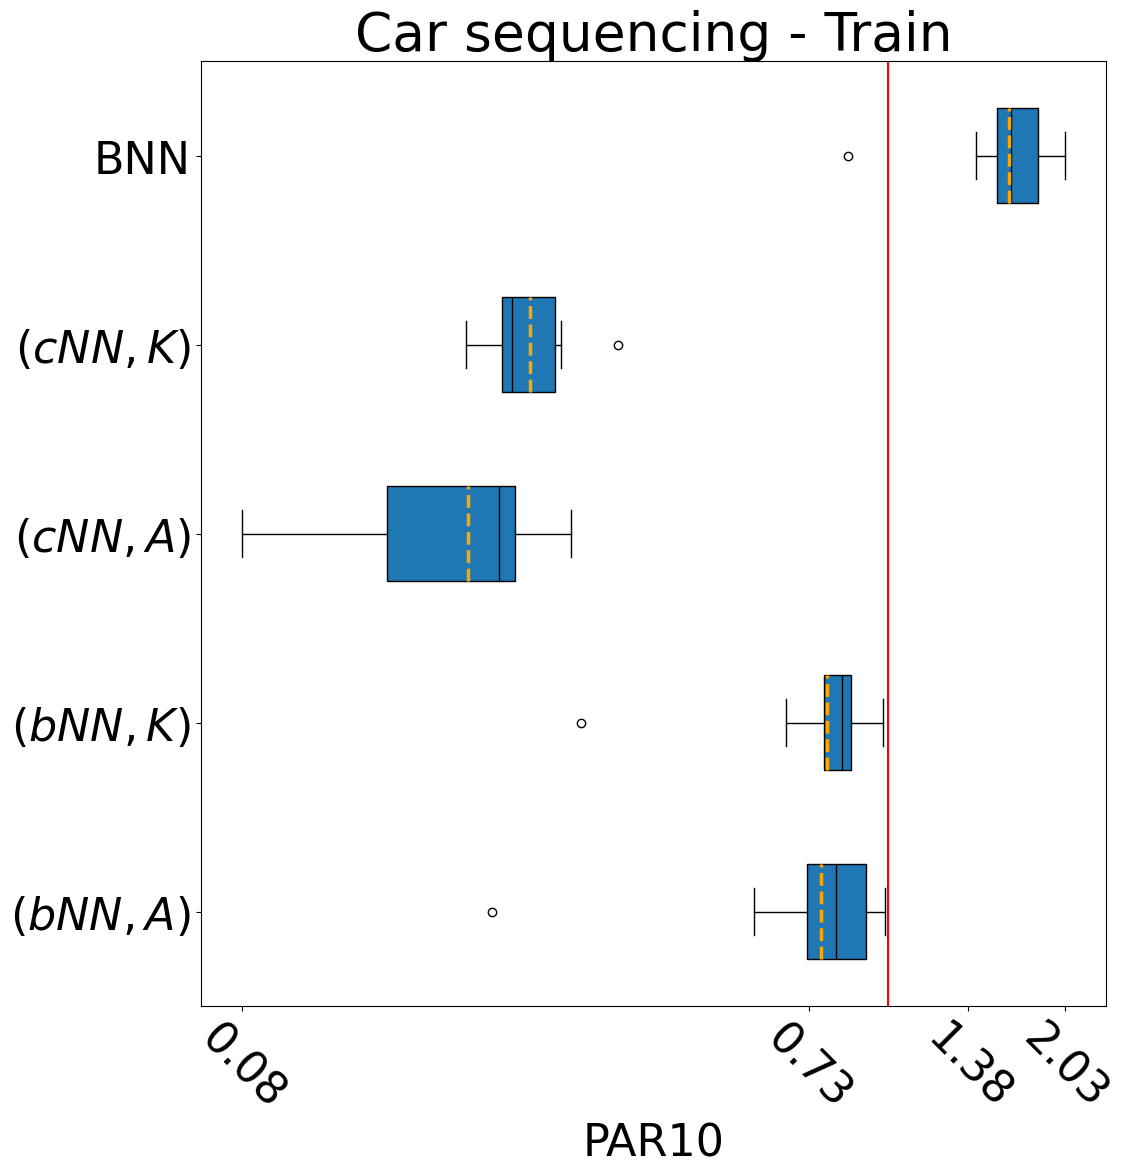

[0.308884457623954, 0.318977092353835, 0.31550693991828127, 0.21926610992144804, 0.30867773852527447, 0.23037982667664955, 0.3177211224086671, 0.3039119244267676, 0.44045572964203816, 0.3368197416407158]


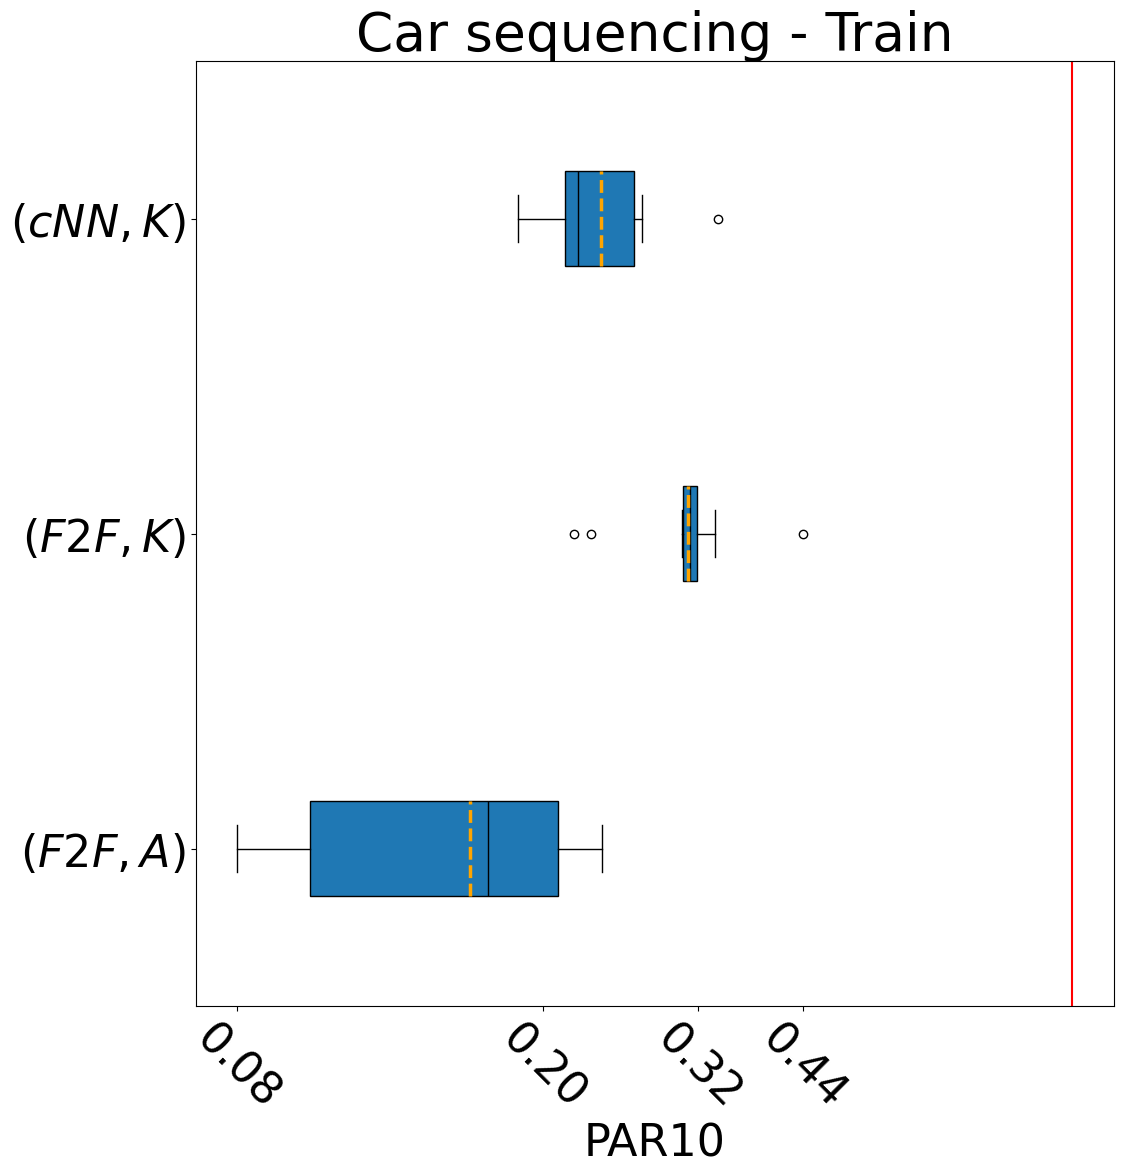

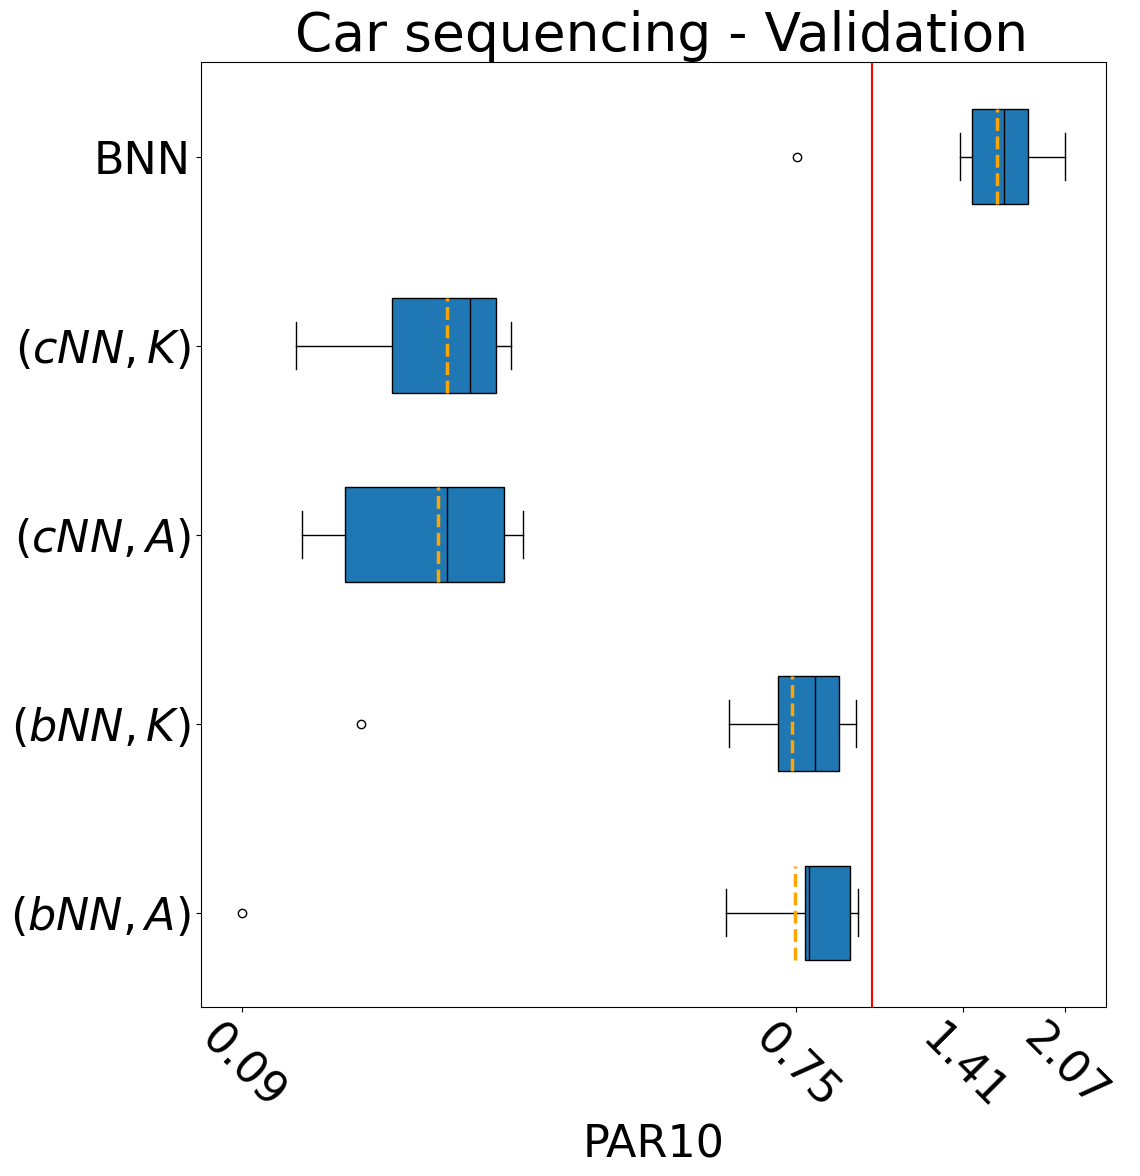

[0.11228025302633218, 0.10319247022728822, 0.08884774855546167, 0.15778552298517085, 0.10336178577391206, 0.08291807757788687, 0.10322809993685599, 0.15001857996819595, 0.1528116334739536, 0.10342424621397131]


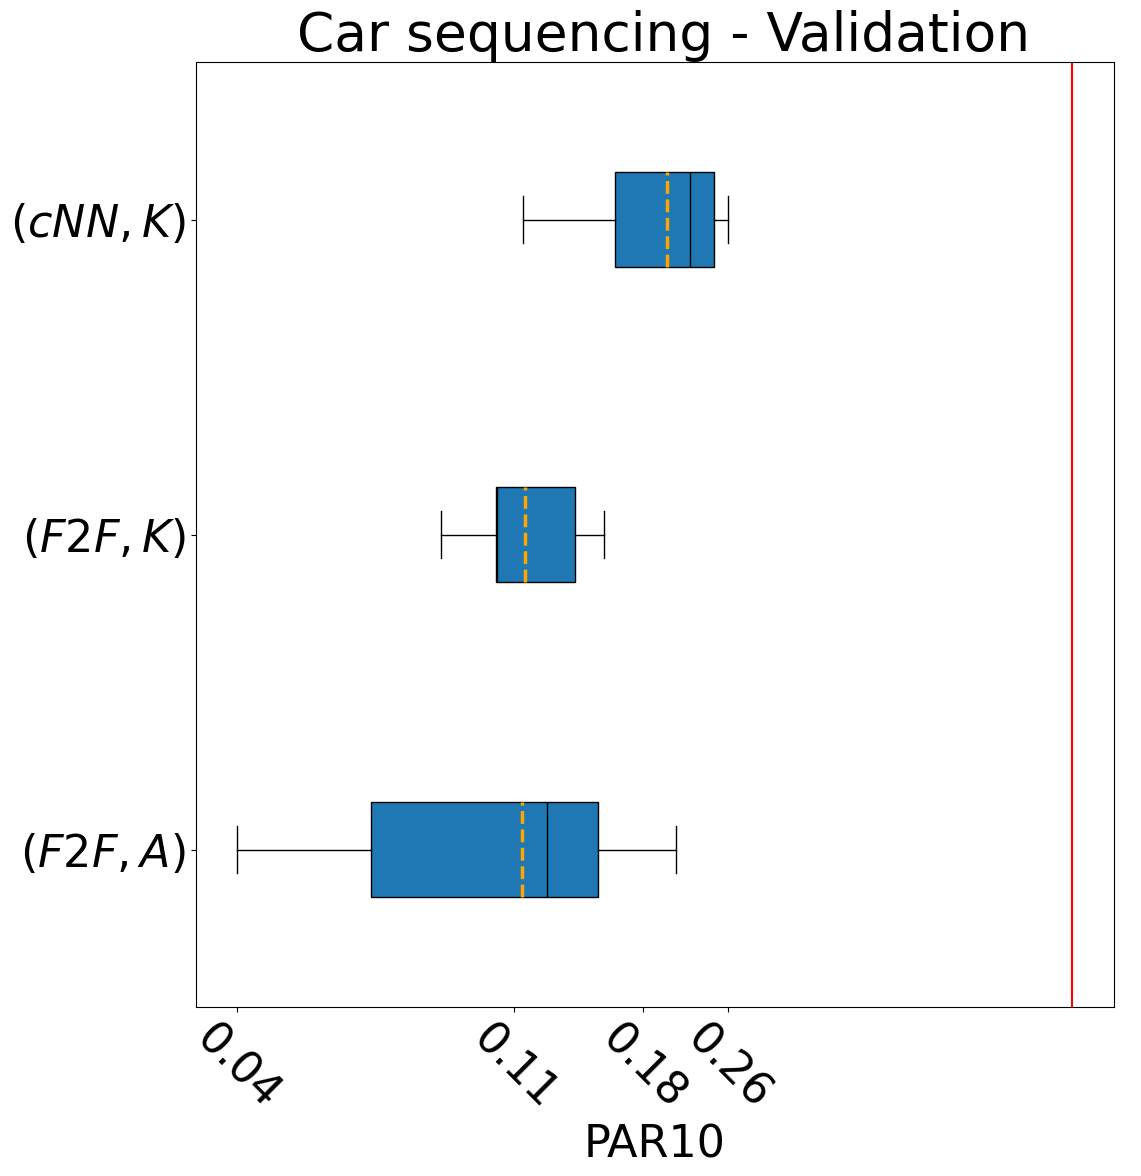

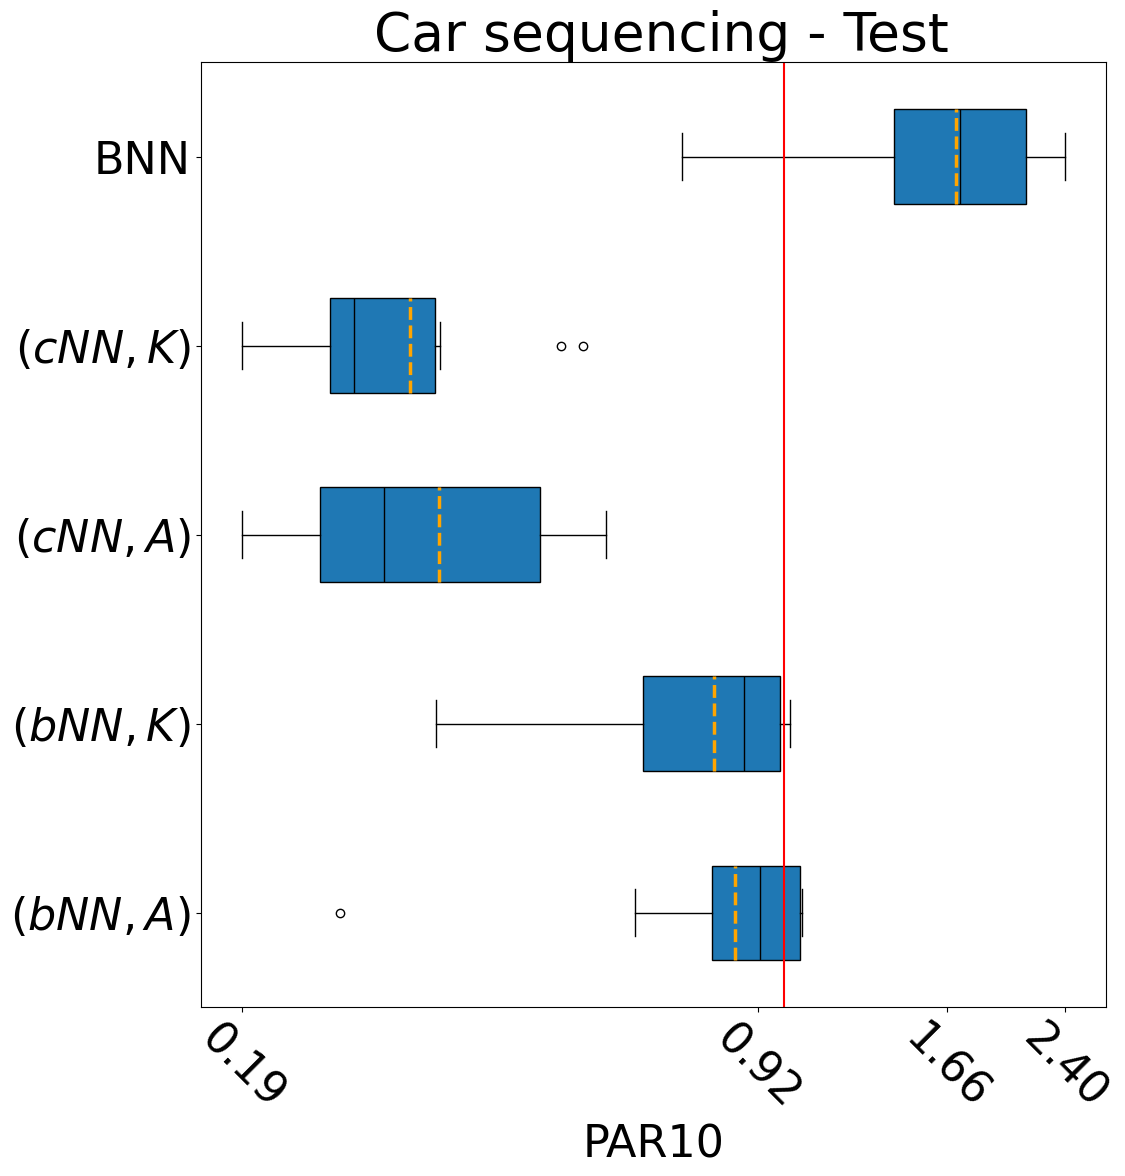

[0.4903918205622737, 0.4620064595450859, 0.3403343307874376, 0.3910955742844433, 0.14417668145732854, 0.4209575918062167, 0.26841065817600795, 0.31499708607720367, 0.3740352070604597, 0.37147789494364614]


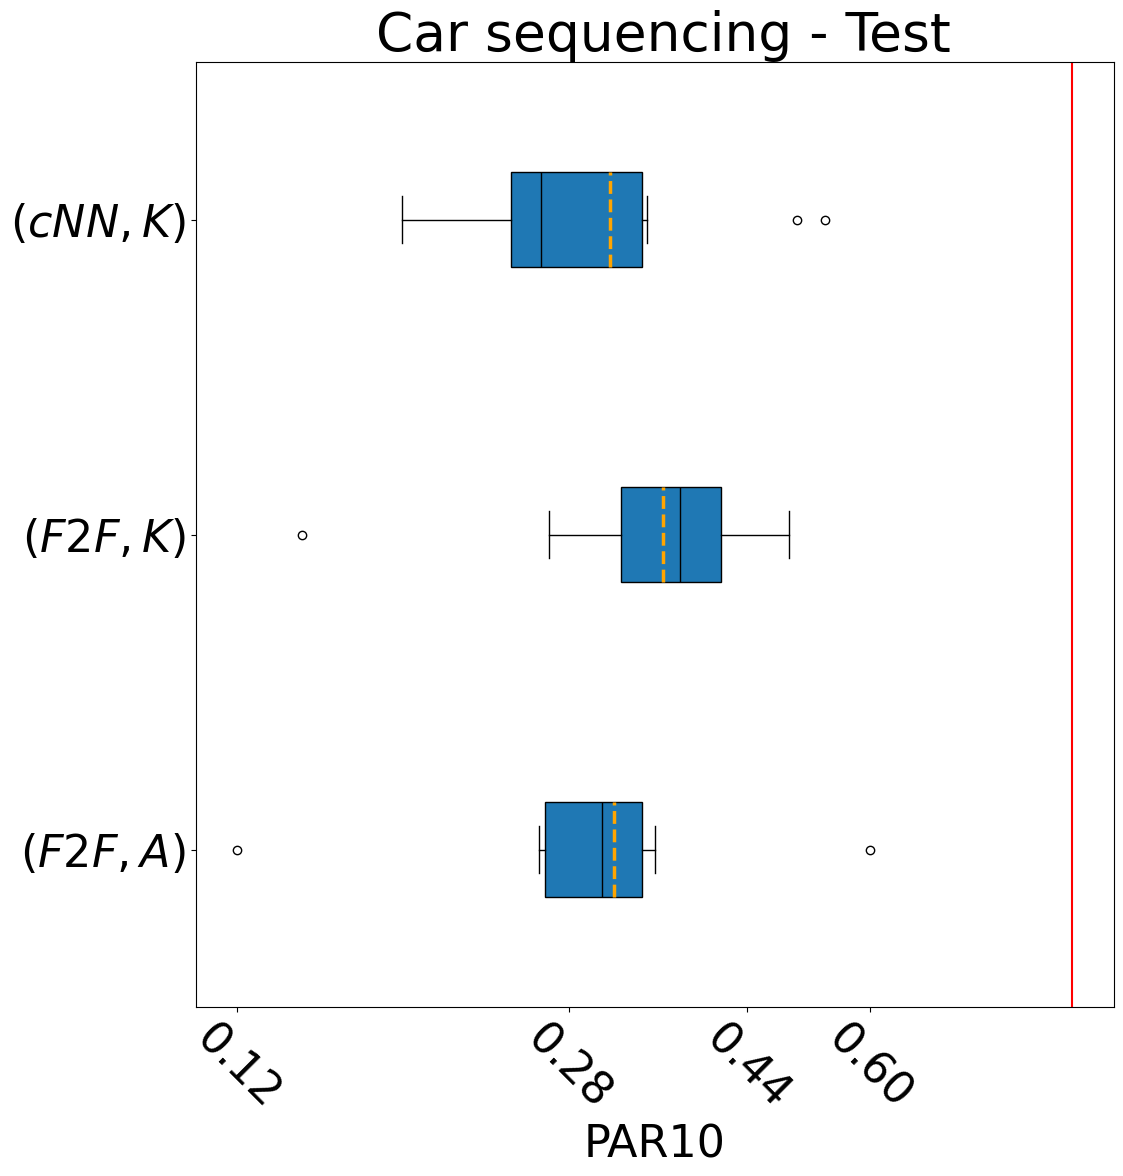

In [47]:
size = 12, 12
import matplotlib
y_label = True
rc('font', size=32)

for set_to_use in ["train", "validation", 'test']:
    plot_predictions = {}
    for key in preditions_dataset.keys():
        try:
            if ("NN" in transform(key) and not "untuned" in key):
                plot_predictions[transform(key)] = list({
                    (v - preditions_dataset['virtual best'][set_to_use][k])/(preditions_dataset[sb_key][set_to_use][k] - preditions_dataset['virtual best'][set_to_use][k]) 
                    for k,v in preditions_dataset[key][set_to_use].items()})
        except Exception as e:
            print(key, e)

    plot = []

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: item[0]))

    # v_line = np.mean(plot_predictions["$SB$"])
    plt.figure(figsize=size)
    plt.boxplot(list(sorted_data.values()),
                vert=False,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
                boxprops=dict(facecolor="#1F78B4"),
                meanline=True,
                medianprops=dict(color='black'))
    if y_label:
        plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))
    else:
        plt.yticks([])

    plt.xscale("log")
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().minorticks_off()
    plt.xticks(np.linspace(np.min(list(sorted_data.values())), np.max(list(sorted_data.values())), num=4), labels=
               [get_label(x) for x in 
                np.linspace(np.min(list(sorted_data.values())), np.max(list(sorted_data.values())), num=4)], rotation=-45)
    # plt.axvline(v_line, color="red")
    plt.axvline(1, color="red")
    plt.xlabel('PAR10')
    plt.ylabel('')
    plt.tight_layout()
    plt.title(pad_around(f"{problem_title} - {set_to_use.capitalize()}"))
    # plt.savefig(f"../data/images/results_{set_to_use}_{problem_class}_NN.pdf", format="pdf", bbox_inches='tight')
    plt.show()
    
    plot_predictions = {}
    for key in preditions_dataset.keys():
        try:
            if ("fully_neural" not in key and not "untuned" in key and key not in combinations and key != 'virtual best') \
                and not '($cNN, A$)' == transform(key) and not 'only' in key:
                plot_predictions[transform(key)] = list({
                    (v - preditions_dataset['virtual best'][set_to_use][k])/(preditions_dataset[sb_key][set_to_use][k] - preditions_dataset['virtual best'][set_to_use][k]) 
                    for k,v in preditions_dataset[key][set_to_use].items()})
        except Exception as e:
            print(key, e)

    plot = []

    sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: item[0]))
    print(sorted_data["($F2F, K$)"])
    # v_line = np.mean(plot_predictions["$SB$"])
    plt.figure(figsize=size)
    plt.boxplot(list(sorted_data.values()),
                vert=False,
                patch_artist=True,
                showmeans=True,
                meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
                boxprops=dict(facecolor="#1F78B4"),
                meanline=True,
                medianprops=dict(color='black'))

    if y_label:
        plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))
    else:
        plt.yticks([])
        
    plt.xscale("log")
    # plt.gca+().get_xaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:.4f}'))
    # plt.xticks(rotation=-45)
    plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    plt.gca().minorticks_off()
    try:
        plt.xticks(np.linspace(np.min(list(sorted_data.values())), np.max(list(sorted_data.values())), num=4), labels=
                [get_label(x) for x in 
                    np.linspace(np.min(list(sorted_data.values())), np.max(list(sorted_data.values())), num=4)], rotation=-45)
    except:
        plt.xticks(rotation=-45)
    plt.axvline(1, color="red")
    plt.xlabel('PAR10')
    plt.ylabel('')
    plt.tight_layout()
    plt.title(pad_around(f"{problem_title} - {set_to_use.capitalize()}"))
    # plt.savefig(f"../data/images/results_{set_to_use}_{problem_class}_comparison.pdf", format="pdf", bbox_inches='tight')
    plt.show()

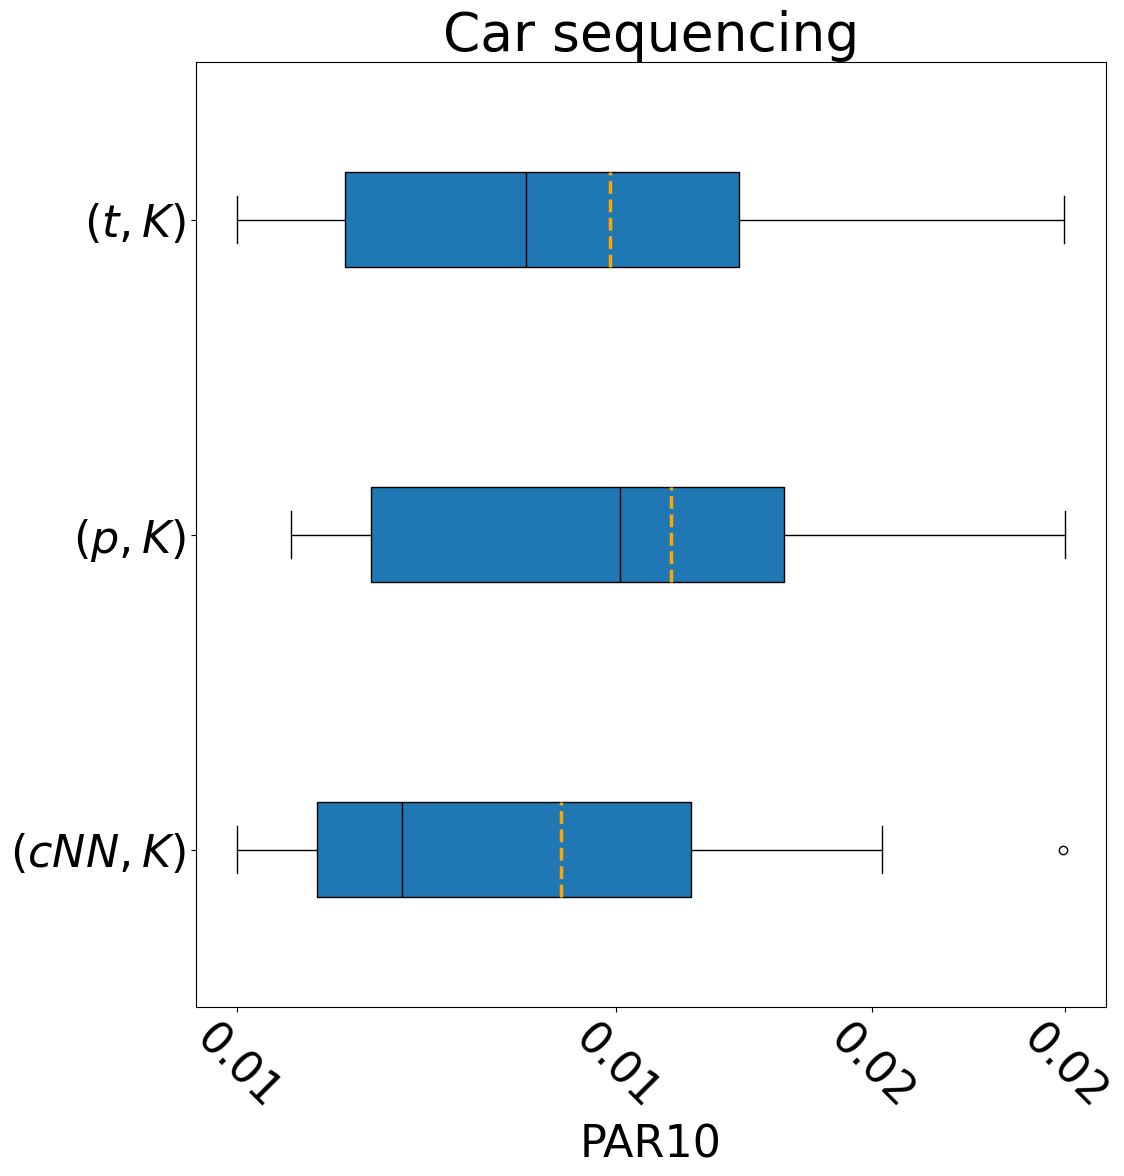

In [48]:
set_to_use = 'test'
import matplotlib
size = 12, 12
y_label = True
plot_predictions = {}
sb = []
for key in preditions_dataset.keys():
    try:
        if transform(key) == '($cNN, K$)' or 'only' in key:
            plot_predictions[transform(key)] = preditions_dataset[key][set_to_use]
            
        if transform(key) == '$SB$':
            sb = preditions_dataset[key][set_to_use]
    except:
        print(key)

sorted_data = dict(sorted(plot_predictions.items(), key=lambda item: item[0]))
sorted_data = {k: {fold:v/sb[fold] for fold, v in elements.items()} for k, elements in sorted_data.items()}
sorted_data = {k: list(elements.values()) for k, elements in sorted_data.items()}
plt.figure(figsize=size)
plt.boxplot(list(sorted_data.values()),
            vert=False,
            patch_artist=True,
            showmeans=True,
            meanprops=dict(linestyle='--', linewidth=2.5, color='orange'),
            boxprops=dict(facecolor="#1F78B4"),
            meanline=True,
            medianprops=dict(color='black'))
if y_label:
    plt.yticks(range(1, len(sorted_data) + 1), list(sorted_data.keys()))
else:
    plt.yticks([])

plt.xscale("log")
plt.gca().get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.gca().minorticks_off()
plt.xticks(np.linspace(np.min(list(sorted_data.values())), np.max(list(sorted_data.values())), num=4), labels=
           [get_label(x) for x in 
            np.linspace(np.min(list(sorted_data.values())), np.max(list(sorted_data.values())), num=4)], rotation=-45)
# plt.axvline(1, color="red")
plt.xlabel('PAR10')
plt.ylabel('')
plt.tight_layout()
plt.title(pad_around(f"{problem_title}"))
plt.savefig(f"../data/images/results_PvTvC_{problem_class}.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [81]:
full_times = {comb: 0 for comb in combinations}
full_times["virtual best"] = 0
for datapoint in dataset:
    for t in datapoint["all_times"]:
        if t["combination"] in full_times:
            full_times[t["combination"]] += t["time"] 
    full_times["virtual best"] += datapoint["time"]
            
full_times = {k:v for k, v in sorted(full_times.items(), key=lambda x: x[1], reverse=True)}

In [82]:
full_times

{'cplex_06_chPrunedLevels_1_2.eprime': 37224106.39,
 'cplex_04_nochPrunedLevels_3.eprime': 36936103.06,
 'cplex_01_compact.eprime': 36792249.67999999,
 'cplex_04_nochPrunedLevels_2.eprime': 36684146.3,
 'chuffed_06_chPrunedLevels_1_2.eprime': 36129836.82000001,
 'or-tools-1_06_chPrunedLevels_1_2.eprime': 36106421.36000001,
 'kissat_06_chPrunedLevels_1_2.eprime': 36096375.650000006,
 'chuffed_04_nochPrunedLevels_3.eprime': 33420670.5,
 'or-tools-1_04_nochPrunedLevels_3.eprime': 33372442.619999994,
 'kissat_04_nochPrunedLevels_3.eprime': 33300790.130000003,
 'chuffed_01_compact.eprime': 4653038.059999999,
 'or-tools-1_01_compact.eprime': 1542387.7999999984,
 'kissat_01_compact.eprime': 1314731.9299999995,
 'or-tools-1_04_nochPrunedLevels_2.eprime': 983779.6100000012,
 'chuffed_04_nochPrunedLevels_2.eprime': 353404.55999999976,
 'kissat_04_nochPrunedLevels_2.eprime': 278999.28999999963,
 'virtual best': 182062.1}

In [83]:
algorithms = set()
for key in full_times.keys():
    if "virtual best" in key:
        continue
    alg = "_".join(key.split("_")[1:])
    algorithms.add(alg)
algorithms = sorted(list(algorithms))
algorithms

['01_compact.eprime',
 '04_nochPrunedLevels_2.eprime',
 '04_nochPrunedLevels_3.eprime',
 '06_chPrunedLevels_1_2.eprime']

In [84]:
def key_transform_algorithms(key):
    if key == "virtual best":
        return "VBS"
    solver = ""
    if "or-tools-1" in key:
        solver = "OR-Tools"
    elif "cplex" in key:
        solver = "CPLEX"
    elif "chuffed" in key:
        solver = "Chuffed"
    elif "kissat" in key:
        solver = "Kissat"
    else:
        raise Exception(f"solver {key} not found")
    model = "_".join(key.split("_")[1:])
    model = "M" + str(algorithms.index(model) + 1)
    return model + "-" + solver

def key_sorter(x):
    k = key_transform_algorithms(x[0])
    if x[0] != "virtual best":
        return k
    else:
        return "M0"
    
def get_color_solver(k):
    if "chuffed" in k:
        return "#5050d9"
    if "cplex" in k:
        return "#fd1e1c"
    if "or-tools" in k:
        return "#7f0a80"
    if "kissat" in k:
        return "#8b8b8b"
    return "#fd1dfe"

def get_color_model(k):
    if "M1" in k:
        return "#168006"
    if "M2" in k:
        return "#fea61f"
    if "M3" in k:
        return "#a42d2d"
    if "M4" in k:
        return "#828c82"
    return "#fd1dfe"

def key_sorter_model(x):
    if x[0] != "virtual best":
        return x[0]
    else:
        return "M0"

In [194]:
print(format(full_times["virtual best"]/full_times[sb_key], ".2f"))

0.73


In [195]:
np.linspace(1, len(full_times.keys()), len(full_times.keys())) - 1

array([0., 1., 2., 3., 4.])

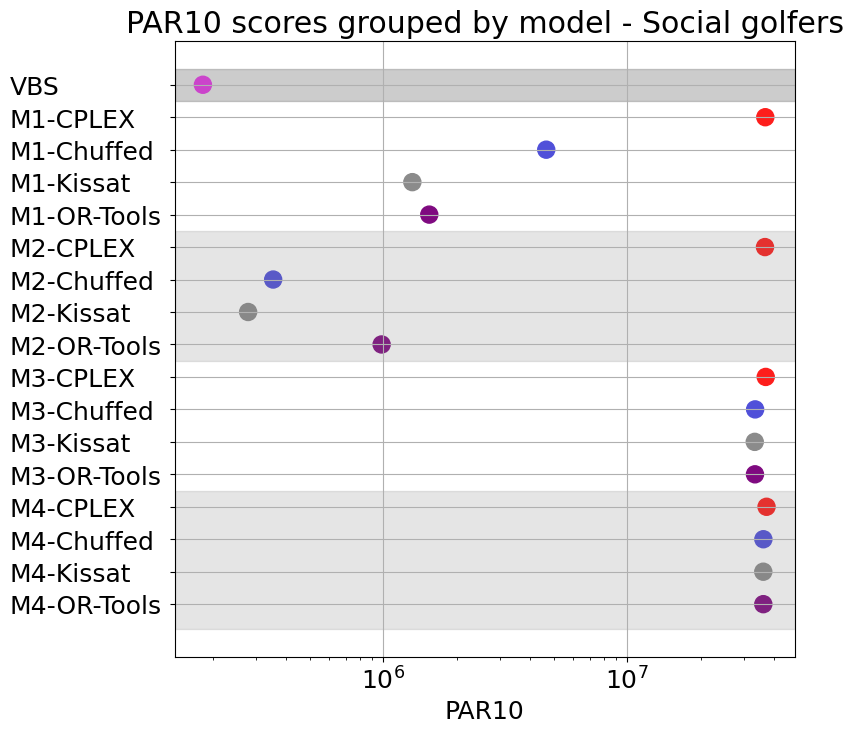

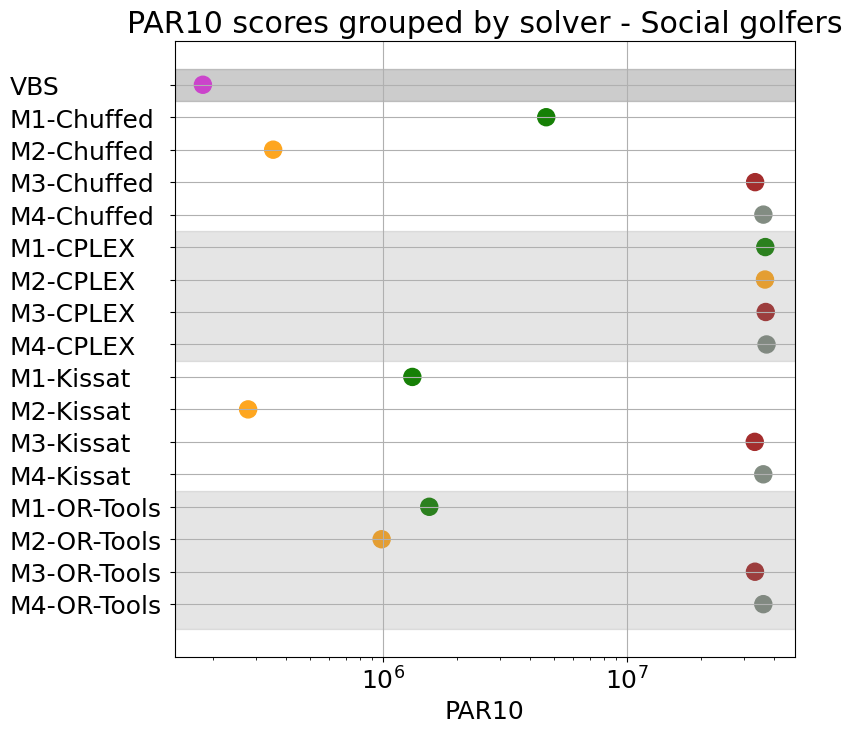

In [85]:
plt.style.use('default')
rc('font', size=18)
fig, axs = plt.subplots(figsize=(8, 8))
full_times = {k:v for k,v in sorted(full_times.items(), key= key_sorter, reverse=True)}
colors = [get_color_solver(k) for k in full_times.keys()]
s = [150 for _ in range(len(full_times.keys()))]
pad_len = max([len(key_transform_algorithms(k)) for  k in full_times.keys()])
yax = np.linspace(1, len(full_times.keys()), len(full_times.keys())) - 1
axs.scatter(list(full_times.values()), yax, c=colors, s=s)
axs.grid(True)
axs.set_yticks(yax, labels=[key_transform_algorithms(k) for  k in full_times.keys()])
axs.axhspan(-0.75, 3.5, color='gray', alpha=0.2)
axs.axhspan(7.5, 11.5, color='gray', alpha=0.2)
axs.axhspan(15.5, 16.5, color='gray', alpha=0.4)
for label in axs.get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.25,0))
axs.set_xscale("log")
axs.set_xlabel("PAR10")
plt.title(f"PAR10 scores grouped by model - {problem_title}")
fig.savefig(f"../data/images/algorithm_time{problem_class}_bymodel.pdf", format="pdf", bbox_inches='tight')
plt.show()

fig, axs = plt.subplots(figsize=(8, 8))

full_times = {k:v for k,v in sorted(full_times.items(), key= key_sorter_model, reverse=True)}
colors = [get_color_model(key_transform_algorithms(k)) for k in full_times.keys()]
s = [150 for _ in range(len(full_times.keys()))]
yax = np.linspace(1, len(full_times.keys()), len(full_times.keys())) - 1
axs.scatter(list(full_times.values()), yax, c=colors, s=s)
axs.grid(True)
axs.set_yticks(yax, labels=[key_transform_algorithms(k) for  k in full_times.keys()])
axs.set_xscale("log")
axs.set_xlabel("PAR10")
axs.axhspan(-0.75, 3.5, color='gray', alpha=0.2)
axs.axhspan(7.5, 11.5, color='gray', alpha=0.2)
axs.axhspan(15.5, 16.5, color='gray', alpha=0.4)
for label in axs.get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.25,0))
plt.title(f"PAR10 scores grouped by solver - {problem_title}")
fig.savefig(f"../data/images/algorithm_time{problem_class}_bysolver.pdf", format="pdf", bbox_inches='tight')
plt.show()

In [86]:
all_wins = {comb: 0 for comb in combinations}
for datapoint in dataset:
    win_comb = datapoint["combination"]
    win_comb = win_comb.replace("06_chPrunedLevels", "01_compact")
    all_wins[win_comb] += 1

all_wins = {comb: v/len(dataset) for comb, v in all_wins.items()}
all_wins

{'chuffed_01_compact.eprime': 0.0009624639076034649,
 'chuffed_04_nochPrunedLevels_2.eprime': 0.9249278152069298,
 'chuffed_04_nochPrunedLevels_3.eprime': 0.0009624639076034649,
 'chuffed_06_chPrunedLevels_1_2.eprime': 0.0,
 'cplex_01_compact.eprime': 0.0,
 'cplex_04_nochPrunedLevels_2.eprime': 0.0028873917228103944,
 'cplex_04_nochPrunedLevels_3.eprime': 0.0,
 'cplex_06_chPrunedLevels_1_2.eprime': 0.0,
 'kissat_01_compact.eprime': 0.0009624639076034649,
 'kissat_04_nochPrunedLevels_2.eprime': 0.06641000962463908,
 'kissat_04_nochPrunedLevels_3.eprime': 0.0,
 'kissat_06_chPrunedLevels_1_2.eprime': 0.0,
 'or-tools-1_01_compact.eprime': 0.0019249278152069298,
 'or-tools-1_04_nochPrunedLevels_2.eprime': 0.0009624639076034649,
 'or-tools-1_04_nochPrunedLevels_3.eprime': 0.0,
 'or-tools-1_06_chPrunedLevels_1_2.eprime': 0.0}

In [87]:
def is_competitive(vb, opt):
    return (opt < 3600 and vb * 2 >= opt) or opt < 10

all_competitive = {comb: 0 for comb in combinations}
for datapoint in dataset:
    for t in datapoint["all_times"]:
        if not "06_chPrunedLevels" in t["combination"]:
            if is_competitive(datapoint["time"], t["time"]):
                all_competitive[t["combination"]] += 1
all_competitive = {comb: v/len(dataset) for comb, v in all_competitive.items()}
all_competitive

{'chuffed_01_compact.eprime': 0.3763233878729548,
 'chuffed_04_nochPrunedLevels_2.eprime': 0.9913378248315688,
 'chuffed_04_nochPrunedLevels_3.eprime': 0.013474494706448507,
 'chuffed_06_chPrunedLevels_1_2.eprime': 0.0,
 'cplex_01_compact.eprime': 0.008662175168431183,
 'cplex_04_nochPrunedLevels_2.eprime': 0.019249278152069296,
 'cplex_04_nochPrunedLevels_3.eprime': 0.007699711260827719,
 'cplex_06_chPrunedLevels_1_2.eprime': 0.0,
 'kissat_01_compact.eprime': 0.4013474494706448,
 'kissat_04_nochPrunedLevels_2.eprime': 0.9634263715110684,
 'kissat_04_nochPrunedLevels_3.eprime': 0.011549566891241578,
 'kissat_06_chPrunedLevels_1_2.eprime': 0.0,
 'or-tools-1_01_compact.eprime': 0.15591915303176132,
 'or-tools-1_04_nochPrunedLevels_2.eprime': 0.44273339749759383,
 'or-tools-1_04_nochPrunedLevels_3.eprime': 0.006737247353224254,
 'or-tools-1_06_chPrunedLevels_1_2.eprime': 0.0}

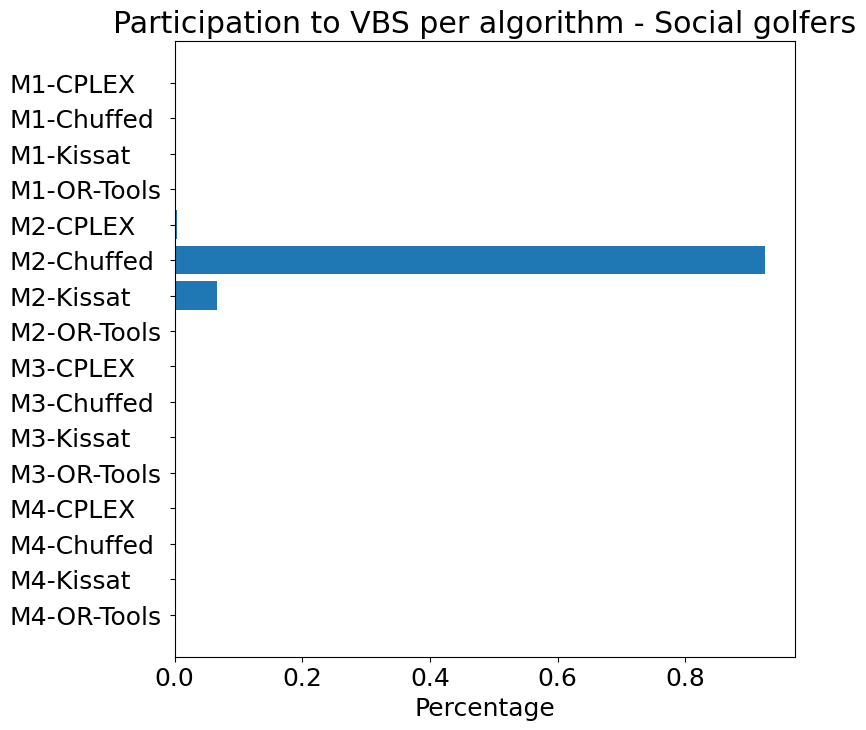

In [88]:
all_wins = {k:v for k,v in sorted(all_wins.items(), key=lambda x: key_transform_algorithms(x[0]), reverse=True)}
plt.style.use('default')
rc('font', size=18)
plt.figure(figsize=(8, 8))
plt.barh([key_transform_algorithms(k) for k in all_wins.keys()], list(all_wins.values()))
for label in plt.gca().get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.25,0))
plt.title(f"Participation to VBS per algorithm - {problem_title}")
plt.xlabel("Percentage")
plt.savefig(f"../data/images/algorithm_wins_vb{problem_class}.pdf", format="pdf", bbox_inches='tight')

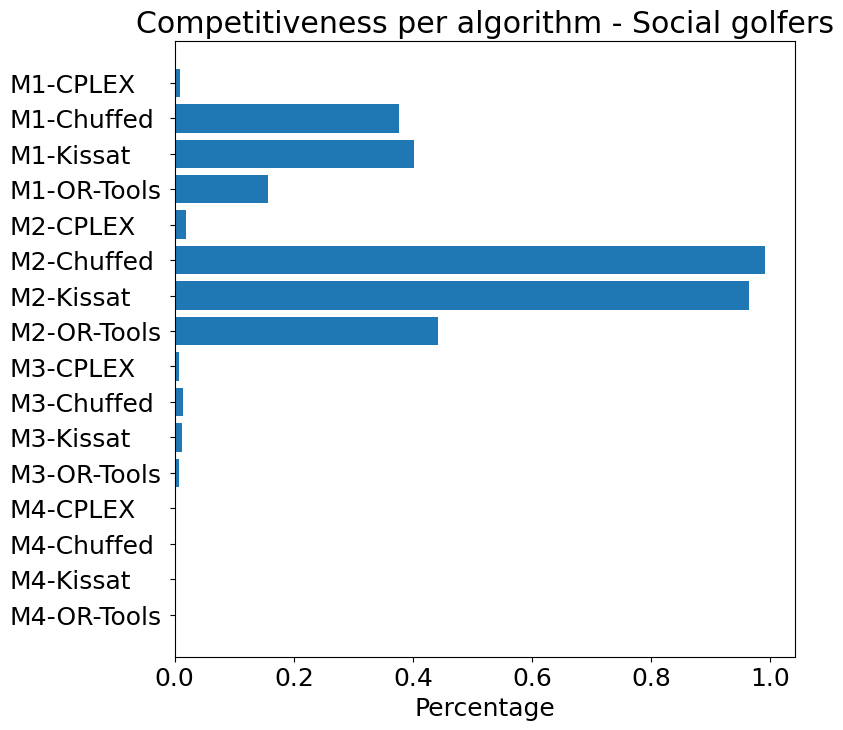

In [89]:
all_competitive = {k:v for k,v in sorted(all_competitive.items(), key=lambda x: key_transform_algorithms(x[0]), reverse=True)}
rc('font', size=18)
plt.figure(figsize=(8, 8))
plt.barh([key_transform_algorithms(k) for k in all_competitive.keys()], list(all_competitive.values()))
for label in plt.gca().get_yticklabels():
    label.set_ha('left')
    label.set_position((-0.25,0))
plt.xlabel("Percentage")
plt.title(f"Competitiveness per algorithm - {problem_title}")
plt.savefig(f"../data/images/algorithm_comp_vb{problem_class}.pdf", format="pdf", bbox_inches='tight')

In [141]:
training_data = {}
problem_class = "CarSequencing"
nn_type = "competitive"
for file in os.listdir(f"../data/history/{problem_class}/{nn_type}"):
    fold = int(file.replace("fold_","").replace(".json",""))
    if not fold in training_data:
        training_data[fold] = {}
    f = open(os.path.join(f"../data/history/{problem_class}/{nn_type}", file))
    training_data[fold] = json.load(f)
    f.close()

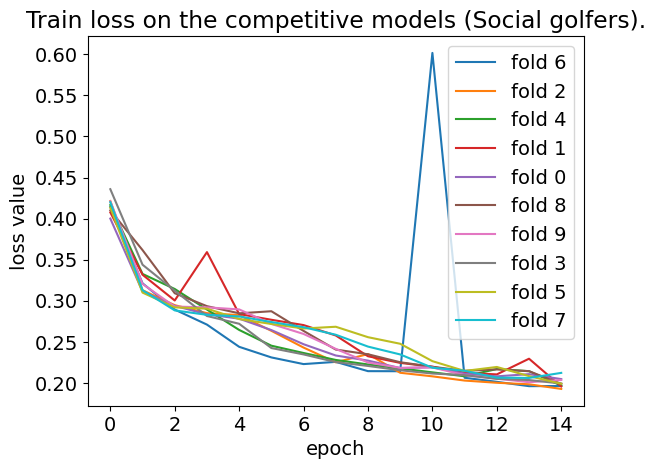

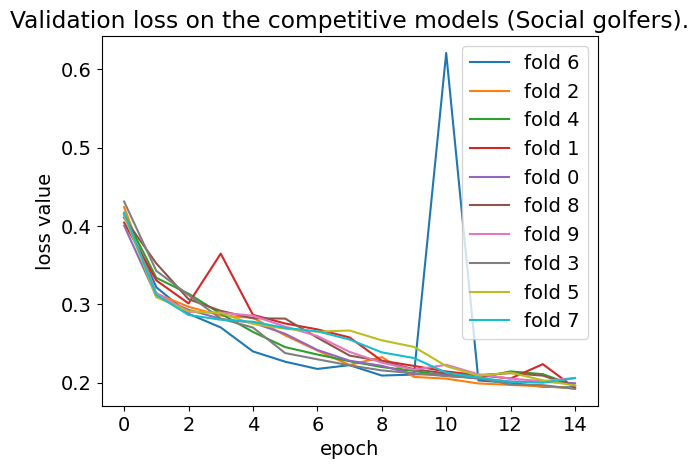

In [142]:
loss_train = {}
loss_val = {}
for v in training_data:
    loss_train[v] = training_data[v]["train"]["loss"]
    loss_val[v] = training_data[v]["validation"]["loss"]
x = [i for i in range(len(loss_train[0]))]
for fold in loss_train:
    plt.plot(x, loss_train[fold], label=f"fold {fold}")
plt.title(f"Train loss on the {'entirely NN' if nn_type == 'fully_neural' else 'competitive'} models ({problem_title}).")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.legend()
plt.savefig(f"../data/images/loss_{problem_class}_train_{nn_type}.pdf", format="pdf", bbox_inches='tight')
plt.show()
for fold in loss_train:
    plt.plot(x, loss_val[fold], label=f"fold {fold}")
plt.title(f"Validation loss on the {'entirely NN' if nn_type == 'fully_neural' else 'competitive'} models ({problem_title}).")
plt.xlabel("epoch")
plt.ylabel("loss value")
plt.legend()
plt.savefig(f"../data/images/loss_{problem_class}_validation_{nn_type}.pdf", format="pdf", bbox_inches='tight')
plt.show()